In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings

In [3]:
warnings.filterwarnings('ignore') #ignore warning messages 
data = pd.read_csv('creditcard.csv')
data.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,182545,125447.0,1.816429,0.146354,0.046576,3.598831,-0.119489,0.764143,-0.673691,0.375930,...,0.235474,0.539597,0.240714,0.691290,-0.349606,-0.055401,-0.011830,-0.033766,18.92,0
1,264950,161666.0,-1.132632,-0.217753,-1.018984,-0.725154,1.624606,-1.123202,0.151016,0.322056,...,0.439623,0.855120,-0.058180,0.115257,-0.786822,0.591033,0.308595,0.055496,24.95,0
2,278614,168323.0,1.754189,0.230348,0.019154,3.927093,-0.087202,0.227146,-0.115704,0.053371,...,-0.374842,-1.136878,0.441901,-0.183241,-0.580846,-0.508929,-0.005608,-0.019285,64.40,0
3,10160,15578.0,1.028419,0.252588,1.744422,2.801771,-0.613426,0.860407,-0.849896,0.375564,...,-0.148324,-0.044123,0.103698,0.142224,0.132222,-0.080803,0.026917,0.016913,0.00,0
4,64,42.0,-0.522666,1.009923,0.276470,1.475289,-0.707013,0.355243,1.559849,-0.399579,...,0.172401,1.011543,0.069666,0.157820,-1.109224,-0.302369,0.318170,0.316910,243.66,0


# Data Visualization

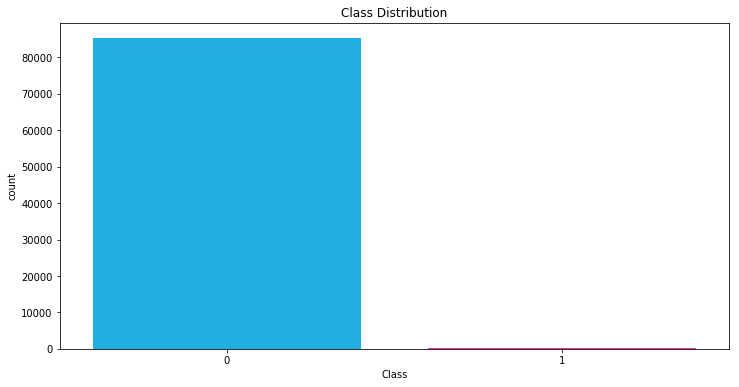

% of normal transacation       : 99.81273846585988
Number of normal transaction   : 85282
% of fraud transacation        : 0.18726153414011845
Number of fraud transaction    : 160


In [6]:
#Graph
my_pal = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Class', data = data, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(data[data['Class']==0])
Count_Fraud_transacation = len(data[data['Class']==1]) 

Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of normal transacation       :', Percentage_of_Normal_transacation*100)
print('Number of normal transaction   :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of fraud transacation        :',Percentage_of_Fraud_transacation*100)
print('Number of fraud transaction    :', Count_Fraud_transacation)

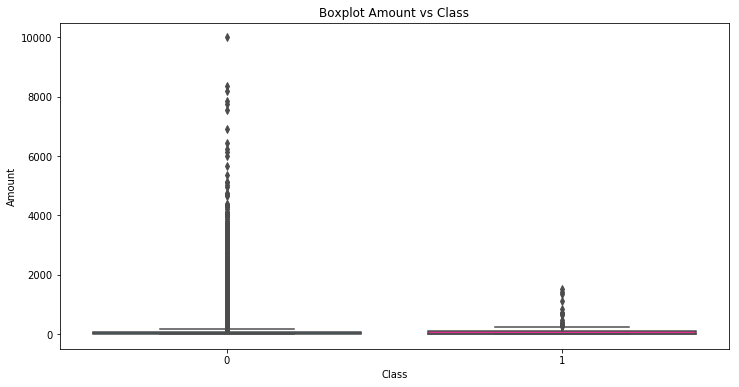

In [7]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x = 'Class', y = 'Amount', data = data, palette = my_pal)
# ax.set_ylim([0, 300])
plt.title('Boxplot Amount vs Class')
plt.show()

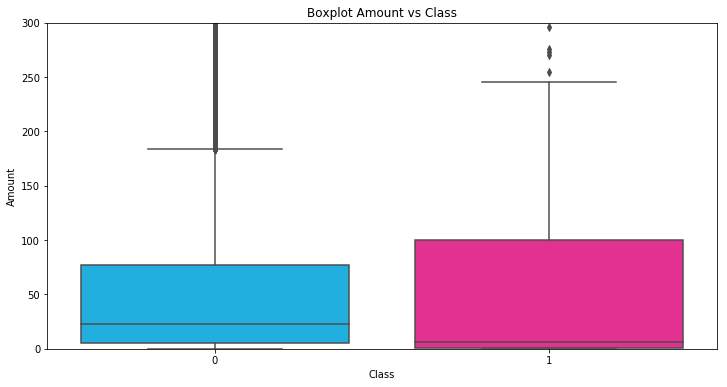

In [8]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x = 'Class', y = 'Amount', data = data, palette = my_pal)
ax.set_ylim([0, 300])
plt.title('Boxplot Amount vs Class')
plt.show()
# 箱子的上线是3/4分位数，下线是1/4分位数。
# boxplot可以用作异常值检验

### split data

In [32]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split (data, test_size = 0.1, random_state = 42)

# Reassign dataset names
data = train_set
valid_data = test_set

In [33]:
# normalization for LR, RF and XGBoost don't need.
# from sklearn.preprocessing import StandardScaler
# data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [34]:
# Drop useless variables
data = data.drop(['Amount','Time'],axis=1)

KeyError: "['Amount' 'Time'] not found in axis"

In [35]:
# def X and Y
y = np.array(data.Class.tolist())
data = data.drop('Class', 1)
X = np.array(data.as_matrix())

# Stratified k-folds
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

AttributeError: 'DataFrame' object has no attribute 'Class'

# Extreme Gradient Boosting (XGBoost)

### 在原始数据上

**<font color='red'> GBDT是回归树，不同的threshold的设置结果一定会有不同，一会要试一下！！！**

In [39]:
# confusion matrix 
# confusion matrix 图都是要自己定义的，自带的confusion matrix方程可以得出4个值
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    
    # 为模块颜色设置threshold，和模型的threshold没关系。
    # GBDT是回归树，不同的threshold的设置结果一定会有不同，一会要试一下！！！
    thresh = cm.max() / 2.
    # !!! product: 两两组合
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        # text(x, y, s）：x, y : scalars，The position to place the text. By default, this is in data coordinates. The coordinate system can be changed using the transform parameter.
        # 注意坐标哦，跟x，y值是相反的
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   

In [40]:
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [41]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [42]:
def plot_precision_recall():
    # Make a step plot.
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    # fill datapoint in between
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [45]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

xgb_cfl.fit(X_train, y_train)

y_pred = xgb_cfl.predict(X_test)
y_pred
# 类别

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
y_score = xgb_cfl.predict_proba(X_test)[:,1]
y_score
# 概率

array([2.2974680e-03, 3.3596950e-04, 7.9036603e-05, ..., 4.6104615e-05,
       4.7714762e-05, 5.8958158e-05], dtype=float32)

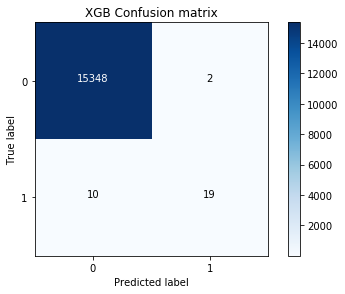

Precision =     0.905
Recall    =     0.655
F1_score  =     0.760


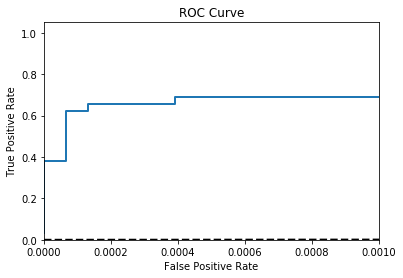

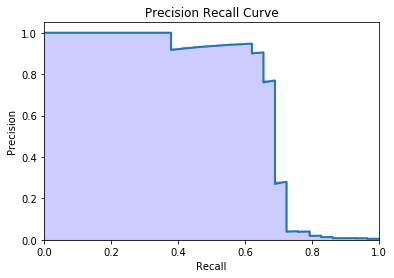

In [47]:
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
# 要用回归值，所以是y_score not y_pred
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

In [23]:
cm.max()

15348

## Under Sampling

In [108]:
data = pd.read_csv('creditcard.csv')
# data = data.drop(['Amount','Time'],axis=1)

X = data.loc[:, data.columns != 'Class'].values
y= data.loc[:, data.columns == 'Class'].values.ravel()

number_frauds=len(data[data.Class==1])
fraud_indices=np.array(data[data.Class==1].index)

normal_indices=data[data.Class==0].index

rand_normal_indices=np.random.choice(normal_indices,number_frauds,replace=False)

# 保留所有fraud的index，和部分选出的unfraud的index，组合起来
under_sample_indices=np.concatenate([fraud_indices,rand_normal_indices])
# 选出下采样后的数据集
under_sample_data=data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class'].values
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class'].values.ravel()

In [109]:
print("Total number of transactions in resampled data: ", len(under_sample_data))

Total number of transactions in resampled data:  320


#### Splitting 原始&下采样 data into train and test set

In [110]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.30, random_state=0)

x_train_undersample,x_test_undersample,y_train_undersample,y_test_undersample=train_test_split(
X_undersample, y_undersample, test_size=0.30, random_state=0)

In [111]:
# xgb
xgb1_cfl = xgb.XGBClassifier(n_jobs = -1)
# 用下采样后的数据训练
xgb1_cfl.fit(x_train_undersample, y_train_undersample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [112]:
# 在原始数据测试集上进行预测
y_pred = xgb1_cfl.predict(x_test)

y_score = xgb1_cfl.predict_proba(x_test)
y_score
# 概率

array([[0.9924705 , 0.0075295 ],
       [0.99721235, 0.00278767],
       [0.9768048 , 0.0231952 ],
       ...,
       [0.47388065, 0.52611935],
       [0.9731069 , 0.02689306],
       [0.99681824, 0.00318173]], dtype=float32)

In [113]:
y_score = y_score[:,1]
# 得到class = 1的概率
y_score

array([0.0075295 , 0.00278767, 0.0231952 , ..., 0.52611935, 0.02689306,
       0.00318173], dtype=float32)

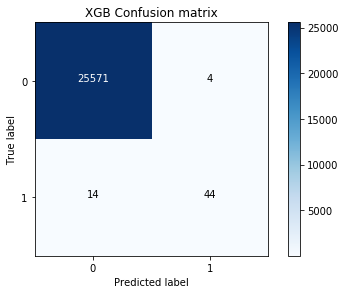

Precision =     0.917
Recall    =     0.759
F1_score  =     0.830


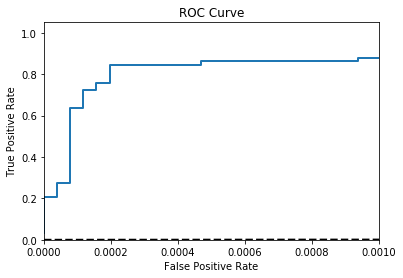

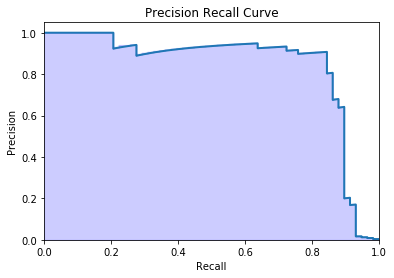

In [135]:
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
# 要用回归值，所以是y_score not y_pred
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
# y_score是数值，不是类别。如果是类别的话，y_test和他之间就
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_underXgb, tpr_underXgb, t_underXgb = fpr, tpr, t
precision_underXgb, recall_underXgb, thresholds_underXgb = precision, recall, thresholds

### 哇，recall大幅提高，但是F1却下降了。
但是如果我们更注重

### 注意哦！
confusion matrix用的是类别预测，因为要计算算对或算错的类别。默认threshold = 0.5

ROC和PRC用的是概率预测，要根据不同的threshold对应不同的TP，TF等。


# Over-sampling

In [231]:
from imblearn.over_sampling import SMOTE

data = pd.read_csv('creditcard.csv')
# data = data.drop(['Amount','Time'],axis=1)

X = data.loc[:, data.columns != 'Class'].values
y= data.loc[:, data.columns == 'Class'].values.ravel()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.30, random_state=0)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 102
Before OverSampling, counts of label '0': 59707 



In [232]:
sm = SMOTE(random_state=2)
# 直接输入数据，自动填平，下采样还得自己random choice。
X_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (119414, 31)
After OverSampling, the shape of train_y: (119414,) 

After OverSampling, counts of label '1': 59707
After OverSampling, counts of label '0': 59707


In [233]:
# xgb
xgb2_cfl = xgb.XGBClassifier(n_jobs = -1)
# 用over采样后的数据训练
xgb2_cfl.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [118]:
# 在原始数据测试集上进行预测
y_pred = xgb2_cfl.predict(x_test)
y_score = xgb2_cfl.predict_proba(x_test)[:,1]
y_score
# 概率

array([0.0009303 , 0.00059837, 0.00360809, ..., 0.00746118, 0.00130731,
       0.00047844], dtype=float32)

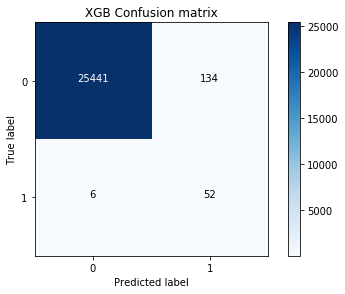

Precision =     0.280
Recall    =     0.897
F1_score  =     0.426


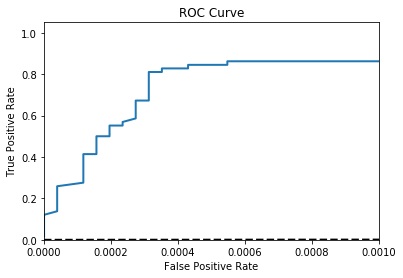

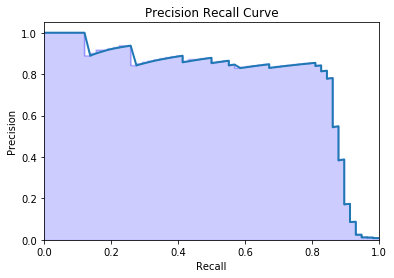

In [119]:
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
# 要用回归值，所以是y_score not y_pred
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

### 感觉结果变差了啊。

### 改变threshold再测一遍

In [238]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds_adj:
    y_score = xgb2_cfl.predict_proba(x_test)[:,1] > i
    cm = confusion_matrix(y_test,y_score)
    print("when threshold = "+str(i))
    show_metrics()
    print("\n")


when threshold = 0.1
Precision =     0.062
Recall    =     0.931
F1_score  =     0.116


when threshold = 0.2
Precision =     0.106
Recall    =     0.914
F1_score  =     0.190


when threshold = 0.3
Precision =     0.157
Recall    =     0.914
F1_score  =     0.268


when threshold = 0.4
Precision =     0.210
Recall    =     0.897
F1_score  =     0.340


when threshold = 0.5
Precision =     0.280
Recall    =     0.897
F1_score  =     0.426


when threshold = 0.6
Precision =     0.351
Recall    =     0.897
F1_score  =     0.505


when threshold = 0.7
Precision =     0.472
Recall    =     0.879
F1_score  =     0.614


when threshold = 0.8
Precision =     0.625
Recall    =     0.862
F1_score  =     0.725


when threshold = 0.9
Precision =     0.778
Recall    =     0.845
F1_score  =     0.810




### 这里竟然是0.9最好，跟下边voting那里0.1最好完全相反啊！！！

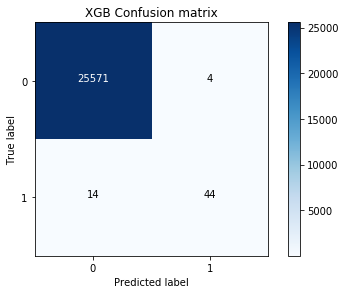

Precision =     0.917
Recall    =     0.759
F1_score  =     0.830


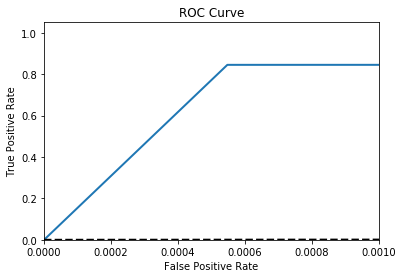

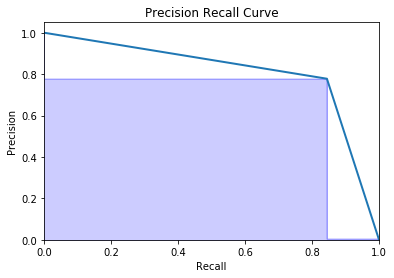

In [239]:
# >0.9就分为fraud类。
y_score = xgb2_cfl.predict_proba(x_test)[:,1] > 0.9
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
# 要用回归值，所以是y_score not y_pred
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

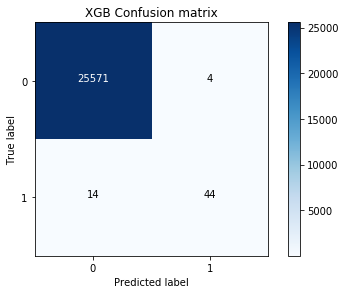

Precision =     0.917
Recall    =     0.759
F1_score  =     0.830


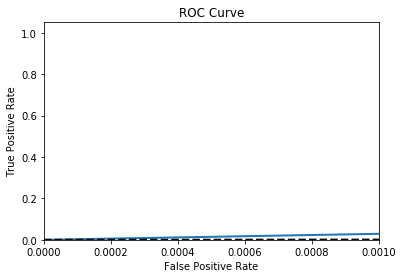

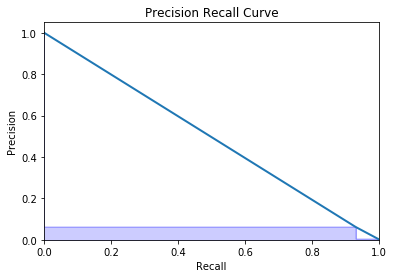

In [240]:
y_score = xgb2_cfl.predict_proba(x_test)[:,1] > 0.1
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

show_metrics()

# ROC curve
# 要用回归值，所以是y_score not y_pred
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

#### 而且我惊讶的发现，threshold = 0.1和0.9的时候，confusion matrix竟然一样，而且Precision =     0.917
Recall    =     0.759
F1_score  =     0.830，也完全一样。只是画ROC和PRC的时候，不一样了。

# Random Forest (RF)

In [104]:
data = pd.read_csv('creditcard.csv')
data = data.drop(['Amount','Time'],axis=1)

X = data.loc[:, data.columns != 'Class'].values
y= data.loc[:, data.columns == 'Class'].values.ravel()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.30, random_state=0)

# Ramdom forest Classifier
rf_cfl = RandomForestClassifier(n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(x_train, y_train)
y_pred = rf_cfl.predict(x_test)
y_score = rf_cfl.predict_proba(x_test)[:,1]

In [105]:
print(y_test.shape)
print(y_pred.shape)

(25633,)
(25633,)


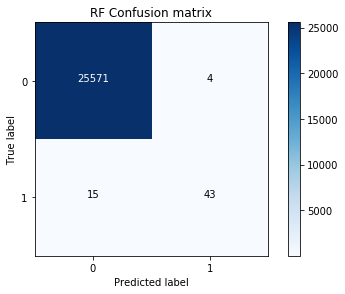

In [106]:
# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
y_test.shape
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.show()

Precision =     0.917
Recall    =     0.759
F1_score  =     0.830


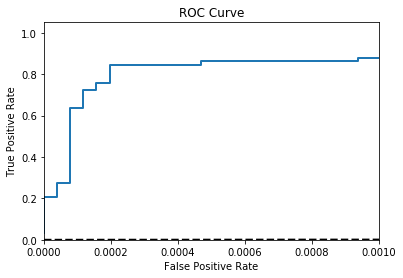

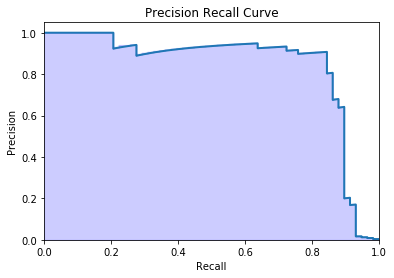

In [134]:
show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

# 下边画所有模型对比的时候要用
fpr_rf, tpr_rf, t_rf = fpr, tpr, t
precision_rf, recall_rf, thresholds_rf = precision, recall, thresholds

fpr_overXgb, tpr_overXgb, t_overXgb = fpr, tpr, t
precision_overXgb, recall_overXgb, thresholds_overXgb = precision, recall, thresholds

### 整体F1变好了，但是recall降低对于这个case一点也不好。

# VotingClassifier = LOG - XGB - RND (F1 = 0.881)

In [123]:
#Voting Classifier
voting_cfl = VotingClassifier (
        estimators = [('xgb_undersample', xgb1_cfl), ('xgb_oversample', xgb2_cfl), ('rf', rf_cfl)],
                     voting='soft', weights = [0.083,0.426,0.819])  # weight depands on F1 score
    
voting_cfl.fit(x_train,y_train)

y_pred = voting_cfl.predict(x_test)
y_score = voting_cfl.predict_proba(x_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
show_metrics()


Precision =     0.894
Recall    =     0.724
F1_score  =     0.800


In [124]:
#Voting Classifier
voting_cfl = VotingClassifier (
        estimators = [('xgb_undersample', xgb1_cfl), ('xgb_oversample', xgb2_cfl), ('rf', rf_cfl)],
                     voting='soft', weights = [1, 0.897,0.741])  # weight depands on recall score
    
voting_cfl.fit(x_train,y_train)

y_pred = voting_cfl.predict(x_test)
y_score = voting_cfl.predict_proba(x_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
show_metrics()


Precision =     0.917
Recall    =     0.759
F1_score  =     0.830


### 以上，用recall做weight整体效果更好。

oversample的recall要好一些，但是其他指标差很远。
over-sample：
Precision =     0.280
Recall    =     0.897
F1_score  =     0.426

# Precision - Recall – Threshold Curve

In [125]:
# 也不知道这是根据啥设的。。。
pr = 0.937
rec = 0.831
t = 0.5

In [127]:
# Precision-recall-threshold curve : 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16, 12))
    plt.title('Precision and Recall Scores (decision threshold)')
    plt.plot(thresholds, precisions[:-1], 'b-',linewidth=2, label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', linewidth=2, label='Recall')
    # 竖线-基线
    plt.axvline(t, color='k', linestyle='--', label='Threshold')
    # 横线-基线
    plt.axhline(pr, color='blue', linewidth=2, linestyle='--')
    plt.axhline(rec, color='green', linewidth=2, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')
#     plt.savefig('5.prec_recc_threshold.png')
    plt.show();

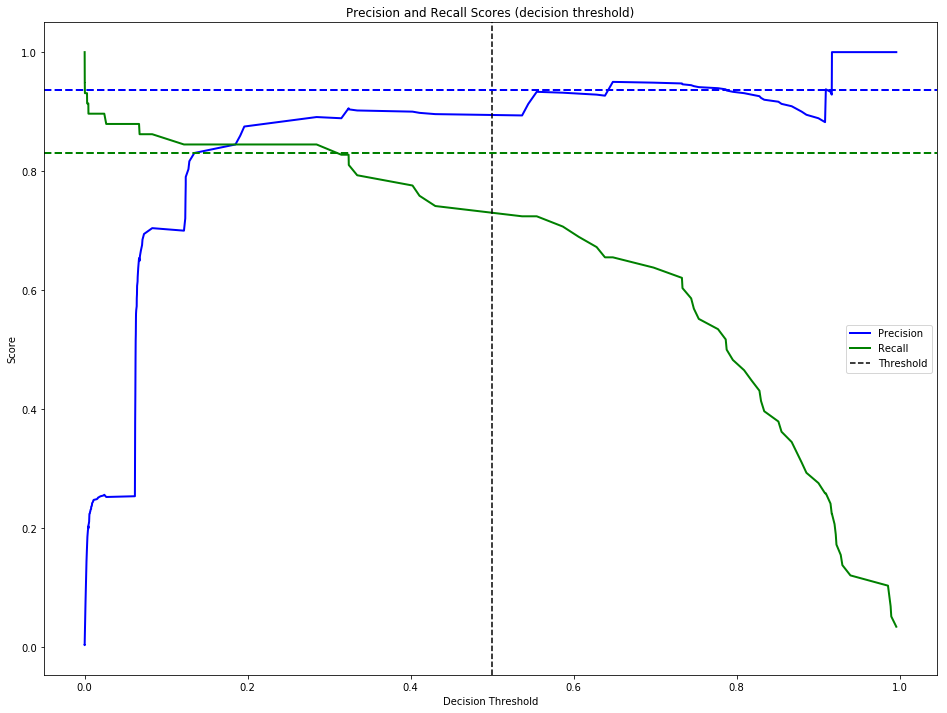

In [128]:
# 随便看看吧，也不知道是谁的precision, recall, thresholds
plot_precision_recall_vs_threshold(precision, recall, thresholds)

# Compare ROC Curves (all models)¶

In [152]:
# 直接一直plot就行，不用subplot
def roc_curve_all_models () : 
    plt.figure(figsize=(16, 12))
    plt.plot(fpr_rf, tpr_rf, label = 'RF ROC curve', linewidth = 8)
    plt.plot(fpr_underXgb, tpr_underXgb, label = 'under-sample XGB ROC curve', linewidth = 5)
    plt.plot(fpr_overXgb, tpr_overXgb, label = 'over-sample XGB ROC curve', linewidth = 2)
    plt.plot(fpr_voting, tpr_voting, label = 'Voting ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(['RF','Under-sample Xgb', 'Over-sample Xgb', 'Voting'], loc='upper left')
#     plt.savefig('6.roc.png')
    plt.show();

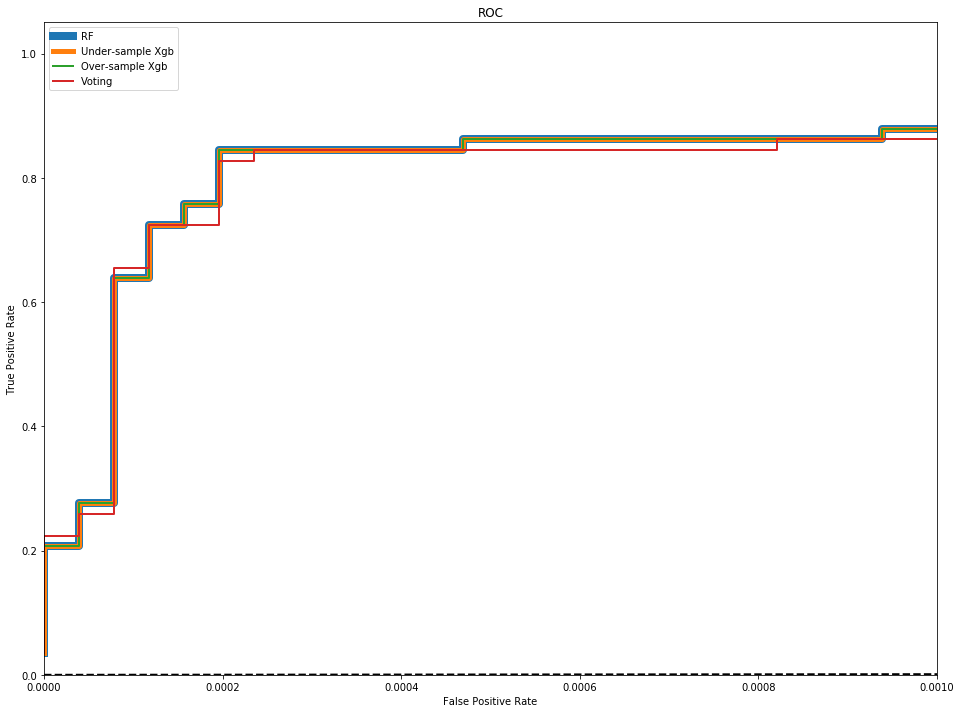

In [153]:
roc_curve_all_models ()
# 什么鬼，前三个模型竟然是重合的

# Compare Precision - Recall Curves (all models)

In [160]:
def prec_recall_all_models () :
    plt.figure(figsize=(16, 12))
    plt.plot(recall_rf, precision_rf, linewidth = 8)
    plt.plot(recall_underXgb, precision_underXgb, linewidth = 5)
    plt.plot(recall_overXgb, precision_overXgb, linewidth = 2)
    plt.plot(recall_voting, precision_voting, linewidth = 2)
    plt.scatter(rec, pr, linewidth = 2, color = 'red')
    plt.axvline(rec, color = 'red', linewidth = 1, linestyle='--')
    plt.axhline(pr, color = 'red', linewidth = 1, linestyle='--')
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve - PR = 0.937 - REC = 0.831 - F1 = 881 ')
    plt.legend(['RF','Under-sample Xgb', 'Over-sample Xgb', 'Voting'], loc='upper right')
    plt.savefig('7.prec_recc.png')
    plt.show();

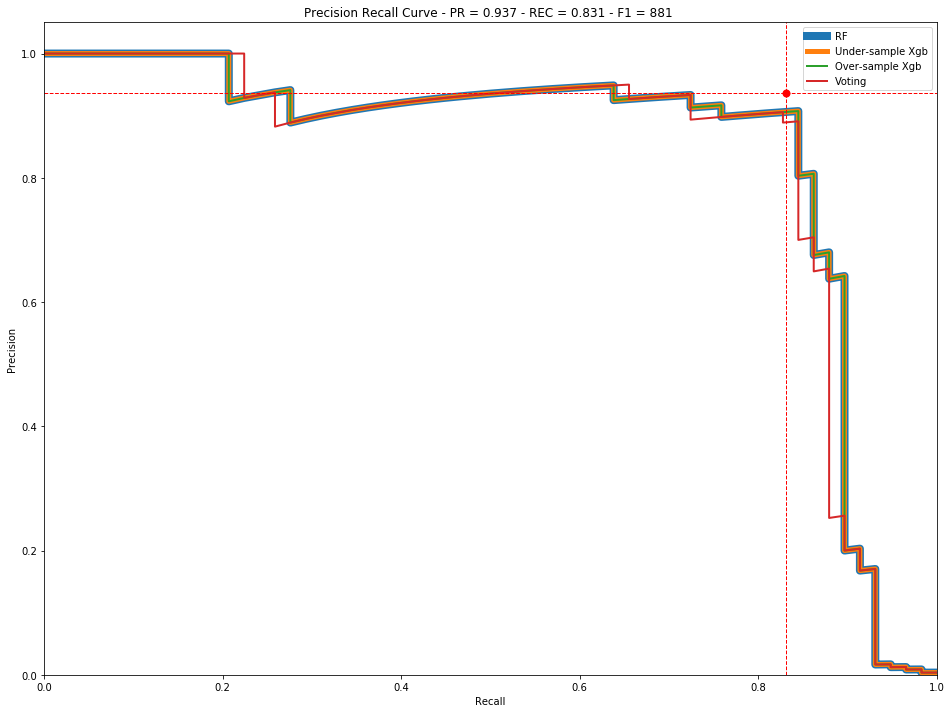

In [161]:
prec_recall_all_models () 
# 天啦噜，什么鬼，前三个模型竟然还是一样的 

# Threshold selection

<img src='https://image.noelshack.com/fichiers/2018/21/1/1526914109-ok-thresh.png'>

### Test

In [208]:
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

j = 1
f1=[]
recall = []
for i in thresholds_adj:
    y_score = voting_cfl.predict_proba(X)[:,1] > i

y_score

array([False, False, False, ..., False, False, False])

In [211]:
int(False)

0

In [214]:
a = False
a

False

In [216]:
a = [False,False,False,False,True]
a

[False, False, False, False, True]

In [229]:
b = [1,1,0,0,1]
c = [0,0,0,0,1]

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

By definition a confusion matrix C is such that $C_{i,j}$ is equal to the number of observations known to be in group i but predicted to be in group j.<br>
Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.

In [222]:
# list中的false被认为是0，不用手动转成int(False)=0. 转了的话只要考虑各种bumpy格式什么的，还会出错。
cm1 = confusion_matrix(a,b)
cm1

array([[2, 2],
       [0, 1]])

In [230]:
cm2 = confusion_matrix(c,b)
cm2

array([[2, 2],
       [0, 1]])

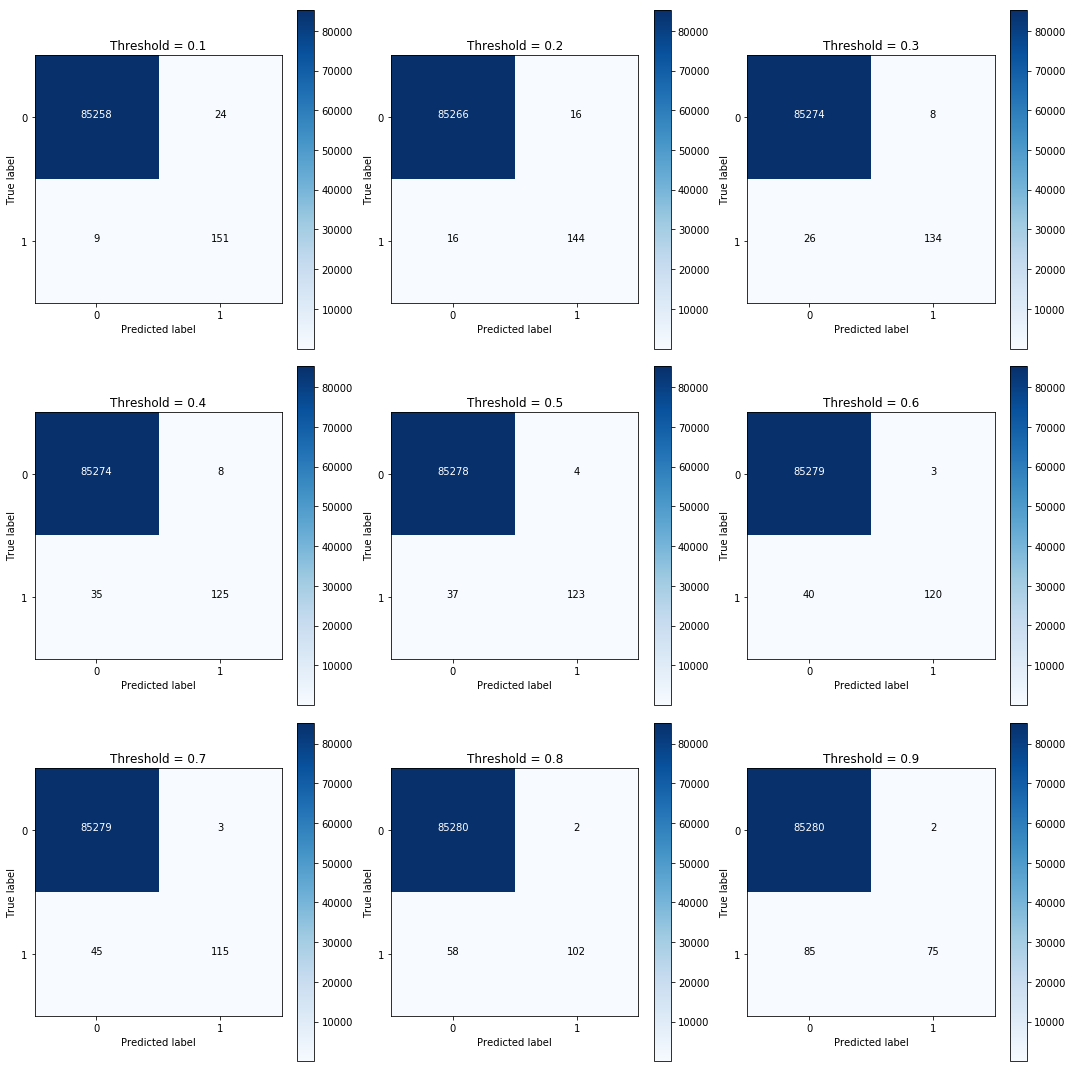

In [227]:
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
f1=[]
recall = []
for i in thresholds_adj:
    y_score = voting_cfl.predict_proba(X)[:,1] > i
    
    # false = 0,true = 1
    
    plt.subplot(3,3,j)
    j += 1
#     print(y_score)
    cm = confusion_matrix(y, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    f1.append((2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))))
    
    recall.append((tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 
    
    # threshold  0.1 最好，这样就会有尽可能多的数据被分到class 1.

In [205]:
frames = [pd.DataFrame(thresholds_adj),pd.DataFrame(f1),pd.DataFrame(recall)]
res = pd.concat(frames,axis=1)
res.columns=[['thresholds_adj','f1','recall']]

In [ ]:
# 用idxmax方法选出每列最大值的行索引标签
max_cols = res.idxmax()
print(max_cols)

In [199]:
unique_max_cols = max_cols.unique()
res.loc[unique_max_cols].style.highlight_max()

### 以上，综合recall，F1，confusion matrix， threshold=0.1最好。